## Opening ASDF extensions in JWST files
Many JWST data products contain an extension in ASDF (Advanced Scientific Data Format).  Astropy includes an asdf library for Python, which is able to read these extensions and extract the data inside.  In this notebook, we'll look at some samples of code using this library in action.

### Import necessary libraries
Import the asdf library as well as a few others we'll need for our file operations.

In [1]:
import asdf
import numpy as np
import os
import pprint
pp = pprint.PrettyPrinter(indent=4)

### Retrieve the ASDF data
We'll start with a module to return the ASDF tree for any JWST .fits file that we pass to it.

In [2]:
def extract_asdf(filename):
    """ Open a given filename using the asdf library and return the asdf tree object.
    
    :param filename:  The file to be opened.
    :type filename:  str
    """
    
    # Get the full filepath
    filepath = os.path.abspath(filename)
    
    # Make sure the provided file exists
    if not os.path.isfile(filepath):
        print("{0} does not exist!".format(filepath))
        return None
    
    # Open the file and pull out the asdf tree
    with asdf.open(filepath) as img:
        asdf_tree = img.tree
        img.close()
        
    # Handle empty tree case
    if len(asdf_tree) == 0:
        print("No ASDF extension found in {0}".format(filepath))
        asdf_tree = None
        
    return asdf_tree

In [3]:
FILE = "jw95065-a3001_s1_nirspec_f100lp-g140m_x1d.fits"
AS_ASDF = extract_asdf(FILE)
pp.pprint(AS_ASDF)

{   'asdf_library': {   'author': 'Space Telescope Science Institute',
                        'homepage': 'http://github.com/spacetelescope/asdf',
                        'name': 'asdf',
                        'version': '1.2.2.dev826'},
    'extra_fits': {   'PRIMARY': {   'header': [   [   'IRAF-TLM',
                                                       '2017-03-03T19:37:00',
                                                       'Time of last '
                                                       'modification'],
                                                   [   'HGA_MOVE',
                                                       False,
                                                       'High Gain Antenna '
                                                       'moved during data '
                                                       'collection'],
                                                   [   'COMMENT',
                                                       

### Extract the spectral table (if applicable)
Some JWST data files, such as the example above, will include a spectral table or other binary data in the ASDF extension.

In [4]:
pp.pprint(AS_ASDF['spec'])

[   {   'meta': {'date': '2017-03-09T11:40:03.994', 'model_type': 'SpecModel'},
        'spec_table': <array (unloaded) shape: [1176] dtype: [('WAVELENGTH', '>f8'), ('FLUX', '>f8'), ('ERROR', '>f8'), ('DQ', '>i4'), ('NET', '>f8'), ('NERROR', '>f8'), ('BACKGROUND', '>f8'), ('BERROR', '>f8')]>}]


As we can see, this binary data in the 'spec_table' remains unloaded until we access it directly as a numpy array.

In [5]:
def get_spec_table(asdf_tree):
    """ Look for a 'spec_table' entry inside the asdf tree and read it into a numpy array.
    
    :param asdf_tree:  The ASDF tree object to operate on.
    :type asdf_tree:  AsdfObject
    """
    
    # Look for a 'spec' entry in the asdf_tree and try to access 'spec_table'
    try:
        spectrum = asdf_tree['spec'][0]
        table = np.array(spectrum['spec_table'])
        
    # May get a key or index error depending on how far the 'spec_table' search gets
    except (KeyError, IndexError):
        table = None
        print("No spectrum found")
        
    return table

In [6]:
TABLE = get_spec_table(AS_ASDF)
print(TABLE)

[( 0.99204794,  -0.83176374,  1., 0,  -0.83176374,  1.,  0.,  1.)
 ( 0.99268565,  -2.25566387,  1., 0,  -2.25566387,  1.,  0.,  1.)
 ( 0.99332336, -21.05964851,  1., 0, -21.05964851,  1.,  0.,  1.) ...,
 ( 1.7400817 ,   0.32447931,  1., 0,   0.32447931,  1.,  0.,  1.)
 ( 1.74071941,   0.15815875,  1., 0,   0.15815875,  1.,  0.,  1.)
 ( 1.74135712,   0.15815875,  1., 0,   0.15815875,  1.,  0.,  1.)]


### Display results
With the binary data loaded, we can now use matplotlib to quickly visualize the contents.

In [7]:
import matplotlib.pyplot as plt

def spec_plot(spec_table):
    """ Use matplotlib to plot flux vs wavelength for an asdf spec_table
    
    :param spec_table:  The numpy array containing spec_table data.
    :type spec_table:  ndarray
    """
    
    # Try to set X and Y
    try:
        x = spec_table['WAVELENGTH']
        y = spec_table['FLUX']
    except ValueError:
        print("spec_plot not given a valid spectral table")
        return
    
    # Create and show the plot
    plt.plot(x, y)
    plt.show()

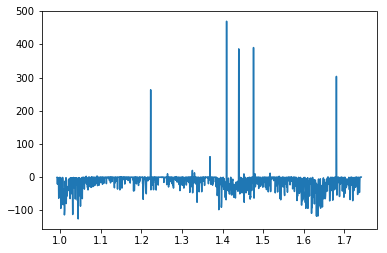

In [8]:
spec_plot(TABLE)

### Save the spectral table to a new file
Now that the spectral table is loaded, it may be useful to save this in a separate .csv file.

In [9]:
def save_numpy_to_csv(np_array, fname):
    """ Save a numpy array to a csv file with headers included.
    
    :param np_array:  The numpy array containing the data we wish to save.
    :type np_array:  ndarray
    
    :param fname:  The desired output filename.
    :type fname:  str
    """
    
    # Get the column headers out of the numpy array
    data_types = np_array.dtype
    column_names = str(data_types.names)
    column_names = column_names.replace('(', '')
    column_names = column_names.replace(')', '')
    
    # Use the savetxt function to save the array to file
    np.savetxt(fname, np_array, delimiter=",", header=column_names, comments='')
    
    print("File saved: {0}".format(fname))

In [10]:
FILENAME = "spec_table.csv"
save_numpy_to_csv(TABLE, FILENAME)

File saved: spec_table.csv
